## Code from

<< https://www.kaggle.com/yasufuminakama/inchi-resnet-lstm-with-attention-starter >>
* Kaggle : Y.Nakama, yasufuminakama

## Module

In [87]:
import numpy as np
import pandas as pd
import gc
import re
import cv2
import os
import time
import math
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau


import torchvision.models as models
from torchvision import transforms

from tqdm.auto import tqdm
tqdm.pandas()

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, Blur
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm
import Levenshtein
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

## Device

In [2]:
if torch.cuda.is_available() : 
    DEVICE = torch.device('cuda')
else : 
    DEVICE = torch.device('cpu')
    
print(torch.__version__, DEVICE)

1.8.0 cuda


In [144]:
# Out of Memory 해결 법
gc.collect()
torch.cuda.empty_cache()

## Constant

In [89]:
PATH = './data/'
TRAIN_DIR = PATH + 'train'

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

class CFG : 
    debug = False
    max_len = 275
    print_freq = 1000
    num_workers = 0
    model_name = 'resnet34'
    size = 224
    scheduler='CosineAnnealingLR'
    epochs = 1
    T_max = 4 
    encoder_lr = 1e-4
    decoder_lr = 4e-4
    min_lr = 1e-6
    batch_size = 16
    weight_decay = 1e-6
    gradient_accumulation_steps = 1
    max_grad_norm = 5
    attention_dim = 256
    embed_dim = 256
    decoder_dim = 512
    dropout = 0.5
    seed = 0
    n_fold = 5
    trn_fold = [0]
    train = True

In [4]:
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

## Data Load

In [5]:
train = pd.read_pickle('train2.pkl')

train.head()

,image_id,InChI,InChI_1,InChI_text,InChI_length
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,C13H20OS,C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 -...,59
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,C21H30O4,C 21 H 30 O 4 /c 1 - 12 ( 22 ) 25 - 14 - 6 - 8...,108
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,C24H23N5O4,C 24 H 23 N 5 O 4 /c 1 - 14 - 13 - 15 ( 7 - 8 ...,112
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,C17H24N2O4S,C 17 H 24 N 2 O 4 S /c 1 - 12 ( 20 ) 18 - 13 (...,108
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,C10H19N3O2S,C 10 H 19 N 3 O 2 S /c 1 - 15 - 10 ( 14 ) 12 -...,72


In [6]:
# Code From https://www.kaggle.com/yasufuminakama/inchi-resnet-lstm-with-attention-starter

class Tokenizer(object):
    
    def __init__(self):
        self.stoi = {}
        self.itos = {}

    def __len__(self):
        return len(self.stoi)
    
    def fit_on_texts(self, texts):
        vocab = set()
        for text in texts:
            vocab.update(text.split(' '))
        vocab = sorted(vocab)
        vocab.append('<sos>')
        vocab.append('<eos>')
        vocab.append('<pad>')
        for i, s in enumerate(vocab):
            self.stoi[s] = i
        self.itos = {item[1]: item[0] for item in self.stoi.items()}
        
    def text_to_sequence(self, text):
        sequence = []
        sequence.append(self.stoi['<sos>'])
        for s in text.split(' '):
            sequence.append(self.stoi[s])
        sequence.append(self.stoi['<eos>'])
        return sequence
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return sequences

    def sequence_to_text(self, sequence):
        return ''.join(list(map(lambda i: self.itos[i], sequence)))
    
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = self.sequence_to_text(sequence)
            texts.append(text)
        return texts
    
    def predict_caption(self, sequence):
        caption = ''
        for i in sequence:
            if i == self.stoi['<eos>'] or i == self.stoi['<pad>']:
                break
            caption += self.itos[i]
        return caption
    
    def predict_captions(self, sequences):
        captions = []
        for sequence in sequences:
            caption = self.predict_caption(sequence)
            captions.append(caption)
        return captions

tokenizer = torch.load('tokenizer2.pth')
print(f"tokenizer.stoi: {tokenizer.stoi}")

tokenizer.stoi: {'(': 0, ')': 1, '+': 2, ',': 3, '-': 4, '/b': 5, '/c': 6, '/h': 7, '/i': 8, '/m': 9, '/s': 10, '/t': 11, '0': 12, '1': 13, '10': 14, '100': 15, '101': 16, '102': 17, '103': 18, '104': 19, '105': 20, '106': 21, '107': 22, '108': 23, '109': 24, '11': 25, '110': 26, '111': 27, '112': 28, '113': 29, '114': 30, '115': 31, '116': 32, '117': 33, '118': 34, '119': 35, '12': 36, '120': 37, '121': 38, '122': 39, '123': 40, '124': 41, '125': 42, '126': 43, '127': 44, '128': 45, '129': 46, '13': 47, '130': 48, '131': 49, '132': 50, '133': 51, '134': 52, '135': 53, '136': 54, '137': 55, '138': 56, '139': 57, '14': 58, '140': 59, '141': 60, '142': 61, '143': 62, '144': 63, '145': 64, '146': 65, '147': 66, '148': 67, '149': 68, '15': 69, '150': 70, '151': 71, '152': 72, '153': 73, '154': 74, '155': 75, '156': 76, '157': 77, '158': 78, '159': 79, '16': 80, '161': 81, '163': 82, '165': 83, '167': 84, '17': 85, '18': 86, '19': 87, '2': 88, '20': 89, '21': 90, '22': 91, '23': 92, '24': 9

In [7]:
train['InChI_length'].max()

275

In [8]:
def get_path(img_name) : 
    return f"{TRAIN_DIR}/{img_name[0]}/{img_name[1]}/{img_name[2]}/{img_name}.png"

train['path'] = train['image_id'].apply(get_path)

In [9]:
train.head()

,image_id,InChI,InChI_1,InChI_text,InChI_length,path
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,C13H20OS,C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 -...,59,./data/train/0/0/0/000011a64c74.png
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,C21H30O4,C 21 H 30 O 4 /c 1 - 12 ( 22 ) 25 - 14 - 6 - 8...,108,./data/train/0/0/0/000019cc0cd2.png
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,C24H23N5O4,C 24 H 23 N 5 O 4 /c 1 - 14 - 13 - 15 ( 7 - 8 ...,112,./data/train/0/0/0/0000252b6d2b.png
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,C17H24N2O4S,C 17 H 24 N 2 O 4 S /c 1 - 12 ( 20 ) 18 - 13 (...,108,./data/train/0/0/0/000026b49b7e.png
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,C10H19N3O2S,C 10 H 19 N 3 O 2 S /c 1 - 15 - 10 ( 14 ) 12 -...,72,./data/train/0/0/0/000026fc6c36.png


In [10]:
class TrainDataset(Dataset) : 
    def __init__(self, df, tokenizer, transform) :
        super().__init__()
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        
    def __len__(self) : 
        return len(self.df)
        
    def __getitem__(self, index) : 
        image_name = self.df.image_id.iloc[index]
        image = cv2.imread(self.df.path.iloc[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        augmented = self.transform(image = image)
        image = augmented['image']
        
        label = self.df.InChI_text.iloc[index]
        label = self.tokenizer.text_to_sequence(label)
        label_length = len(label)
        label_length = torch.LongTensor([label_length])
        return image, torch.LongTensor(label), label_length

In [11]:
class TestDataset(Dataset) : 
    def __init__(self, df, transform = None) : 
        super().__init__()
        self.df = df
        self.transform = transform
        
    def __len__(self) : 
        return len(self.df)
    
    def __getitem__(self, idx) : 
        path = self.df.path.iloc[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        
        augmented = self.transform(image = image)
        image = augmented['image']
        return image

In [12]:
Transform = Compose([
    Resize(CFG.size, CFG.size),
    Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225],
    ),
    ToTensorV2(),
])

In [13]:
trainset = TrainDataset(train, tokenizer, Transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


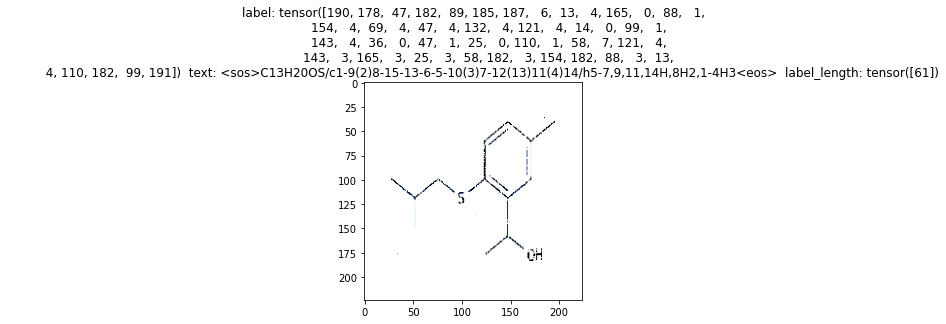

In [14]:
for i in range(1) : 
    image, label, label_length = trainset[i]
    text = tokenizer.sequence_to_text(label.numpy())
    plt.imshow(image.transpose(0, 1).transpose(1, 2))
    plt.title(f'label: {label}  text: {text}  label_length: {label_length}')
    plt.show() 

## Model

In [15]:
model = timm.create_model(CFG.model_name, pretrained = False)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [16]:
out_test_val = torch.randn(2, 3, 224, 224)
print(out_test_val.shape)
out_test = model(out_test_val)
print(f'shape : {out_test.shape}')
model.global_pool = nn.Identity()
model.fc = nn.Identity()
model

torch.Size([2, 3, 224, 224])
shape : torch.Size([2, 1000])


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [17]:
class Encoder(nn.Module) : 
    def __init__(self, model_name = 'resnet34', pretrained = False) :
        super().__init__()
        self.cnn = timm.create_model(model_name, pretrained = pretrained)
        self.n_features = self.cnn.fc.in_features
        self.cnn.global_pool = nn.Identity()
        self.cnn.fc = nn.Identity()
        
    def forward(self, x) : 
        bs = x.size(0)
        features = self.cnn(x)
        features = features.permute(0, 2, 3, 1)
        return features

feature 크기가 안맞음.

In [18]:
class Attention(nn.Module) : 
    def __init__(self, encoder_dim, decoder_dim, attention_dim) : 
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, encoder_out, decoder_hidden) : 
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim = 1)
        return attention_weighted_encoding, alpha

In [55]:
class DecoderWithAttention(nn.Module) : 
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, device, encoder_dim = 512, dropout = 0.5) : 
        super(DecoderWithAttention, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout
        self.device = device
        
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p = self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias = True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.init_weights()
        
    def init_weights(self) : 
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        
    def load_pretrained_embeddings(self, embeddings) : 
        self.embedding.weight = nn.Parameter(embeddings)
        
    def fine_tune_embeddings(self, fine_tune = True) : 
        for p in self.embedding.parameters() : 
            p.requires_grad = fine_tune
            
    def init_hidden_state(self, encoder_out) : 
        mean_encoder_out = encoder_out.mean(dim = 1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c
    
    def forward(self, encoder_out, encoded_captions, caption_lengths) : 
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        num_pixels = encoder_out.size(1)
        
        caption_length, sort_ind = caption_lengths.squeeze(1).sort(dim = 0, descending = True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]
        embeddings = self.embedding(encoded_captions)
        
        h, c = self.init_hidden_state(encoder_out)
        
        decode_lengths = (caption_length - 1).tolist()
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(self.device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(self.device)
        
        for t in range(max(decode_lengths)) : 
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim = 1),
                                   (h[:batch_size_t], c[:batch_size_t]))
            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
            
        return predictions, encoded_captions, decode_lengths, alphas, sort_ind
    
    def predict(self, encoder_out, decode_lengths, tokenizer) : 
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        num_pixels = encoder_out.size(1)
        
        start_tockens = torch.ones(batch_size, dtype = torch.long).to(self.device) * tokenizer.stoi["<sos>"]
        embeddings = self.embedding(start_tockens)
        h, c = self.init_hidden_state(encoder_out)
        predictions = torch.zeros(batch_size, decode_lengths, vocab_size).to(self.device)
        
        for t in range(decode_lengths) : 
            attention_weighted_encoding, alpha = self.attention(encoder_out, h)
            gate = self.sigmoid(self.f_beta(h))
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(torch.cat([embeddings, attention_weighted_encoding], dim = 1),
                                   (h, c))
            preds = self.fc(self.dropout(h))
            predictions[:, t, :] = preds
            
            if np.argmax(preds.detach().cpu().numpy() == tokenizer.stoi["<eos>"]) : 
                break
                
            embeddings = self.embedding(torch.argmax(preds, -1))
        return predictions    

In [20]:
embedding = nn.Embedding(30, 512)
print(embedding.weight.data)
print(embedding.weight.data.uniform_(-0.1, 0.1))

tensor([[-1.3590e+00,  1.4441e+00, -1.1384e+00,  ..., -6.9568e-01,
         -3.9267e-01,  5.2665e-02],
        [ 1.5229e+00,  1.2978e-01, -1.3078e-01,  ...,  1.9092e+00,
         -9.0539e-02,  1.7844e-01],
        [ 5.1041e-01, -6.6608e-01,  4.5714e-01,  ...,  5.2256e-01,
          6.0595e-01,  7.8811e-01],
        ...,
        [-2.2162e+00,  7.6062e-01,  1.6445e+00,  ...,  2.7885e-01,
          7.6472e-01, -2.1954e-01],
        [-4.2373e-01, -5.5159e-01, -2.9657e+00,  ..., -1.3615e+00,
          6.0430e-01,  7.2182e-01],
        [ 3.7746e-01,  4.4349e-01, -1.0430e+00,  ..., -4.9108e-01,
          1.0661e+00,  9.0648e-05]])
tensor([[ 0.0432, -0.0519,  0.0568,  ...,  0.0788, -0.0579,  0.0184],
        [-0.0188,  0.0552, -0.0670,  ...,  0.0885,  0.0766,  0.0682],
        [-0.0841,  0.0961,  0.0265,  ..., -0.0469, -0.0735, -0.0437],
        ...,
        [ 0.0724,  0.0654, -0.0564,  ...,  0.0839,  0.0987,  0.0719],
        [-0.0218, -0.0901,  0.0120,  ..., -0.0148,  0.0370, -0.0148],
     

In [21]:
fc = nn.Linear(512, 30)
fc.bias.data

tensor([-0.0301,  0.0238,  0.0029, -0.0391,  0.0263, -0.0181,  0.0389, -0.0014,
         0.0014, -0.0090, -0.0212,  0.0014,  0.0052,  0.0150, -0.0096, -0.0041,
        -0.0211,  0.0124,  0.0297, -0.0251, -0.0082,  0.0298, -0.0408, -0.0002,
         0.0160,  0.0003, -0.0123, -0.0374,  0.0436, -0.0412])

In [22]:
rnd = torch.randn(2, 3, 224, 224)
print(rnd)
nn.Parameter(rnd)

tensor([[[[-0.3044,  0.7540, -1.5177,  ...,  0.6235, -0.0899,  3.0908],
          [ 0.5901, -1.4152, -0.2312,  ..., -1.8907,  1.9177,  0.5691],
          [-0.3886, -1.4381, -0.8307,  ..., -0.4119, -0.5074,  1.1393],
          ...,
          [-0.4840, -1.0250, -0.4982,  ...,  0.6701,  0.2114,  1.4567],
          [ 1.4101,  0.9289,  0.6544,  ...,  2.7610,  0.2670, -0.0039],
          [ 2.0325, -0.2024, -2.0813,  ...,  1.2517,  1.5438,  0.1431]],

         [[ 0.6788, -0.6160, -0.0460,  ...,  1.2763, -0.9281,  0.4504],
          [-1.5570, -0.1272,  2.0995,  ...,  0.5402,  0.5966,  0.8183],
          [ 1.2140,  2.6829, -0.4258,  ...,  0.5324, -1.4423, -1.2142],
          ...,
          [-0.4453, -0.6367,  1.1478,  ..., -1.4535, -2.4058,  0.4512],
          [-0.7411, -0.2841, -0.1344,  ...,  0.9410, -0.1128, -0.9692],
          [-1.0666, -0.2804, -0.9853,  ..., -0.4616, -0.9477, -0.3935]],

         [[ 0.5055, -0.6264,  0.4532,  ...,  0.8404,  1.7172,  0.7068],
          [-0.1991,  1.0388,  

Parameter containing:
tensor([[[[-0.3044,  0.7540, -1.5177,  ...,  0.6235, -0.0899,  3.0908],
          [ 0.5901, -1.4152, -0.2312,  ..., -1.8907,  1.9177,  0.5691],
          [-0.3886, -1.4381, -0.8307,  ..., -0.4119, -0.5074,  1.1393],
          ...,
          [-0.4840, -1.0250, -0.4982,  ...,  0.6701,  0.2114,  1.4567],
          [ 1.4101,  0.9289,  0.6544,  ...,  2.7610,  0.2670, -0.0039],
          [ 2.0325, -0.2024, -2.0813,  ...,  1.2517,  1.5438,  0.1431]],

         [[ 0.6788, -0.6160, -0.0460,  ...,  1.2763, -0.9281,  0.4504],
          [-1.5570, -0.1272,  2.0995,  ...,  0.5402,  0.5966,  0.8183],
          [ 1.2140,  2.6829, -0.4258,  ...,  0.5324, -1.4423, -1.2142],
          ...,
          [-0.4453, -0.6367,  1.1478,  ..., -1.4535, -2.4058,  0.4512],
          [-0.7411, -0.2841, -0.1344,  ...,  0.9410, -0.1128, -0.9692],
          [-1.0666, -0.2804, -0.9853,  ..., -0.4616, -0.9477, -0.3935]],

         [[ 0.5055, -0.6264,  0.4532,  ...,  0.8404,  1.7172,  0.7068],
        

In [23]:
rnd = torch.randn(2, 8, 4, 2)
print(rnd.shape)
rnd = rnd.mean(dim = 1)
print(rnd.shape)

torch.Size([2, 8, 4, 2])
torch.Size([2, 4, 2])


In [24]:
rnd = torch.randn(8, 1)
print(rnd)
rnd = rnd.squeeze(1)
print(rnd)
rnd = rnd.sort(dim = 0, descending = True)
print(rnd)

tensor([[ 0.8069],
        [ 0.1675],
        [ 0.8866],
        [-1.6333],
        [-1.2031],
        [-1.3319],
        [ 0.4917],
        [ 0.2780]])
tensor([ 0.8069,  0.1675,  0.8866, -1.6333, -1.2031, -1.3319,  0.4917,  0.2780])
torch.return_types.sort(
values=tensor([ 0.8866,  0.8069,  0.4917,  0.2780,  0.1675, -1.2031, -1.3319, -1.6333]),
indices=tensor([2, 0, 6, 7, 1, 4, 5, 3]))


In [25]:
dleng = [5, 9]
for t in range(max(dleng)) : 
    batch_size_t = sum([l > t for l in dleng])
    print(batch_size_t)

2
2
2
2
2
1
1
1
1


In [26]:
start_tokens = torch.ones(16, dtype = torch.long).to(DEVICE) * tokenizer.stoi["<sos>"]
start_tokens

tensor([190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190,
        190, 190], device='cuda:0')

## Helper functions

In [27]:
def get_score(y_true, y_pred) : 
    scores = []
    
    for true, pred in zip(y_true, y_pred) : 
        score = Levenshtein.distance(true, pred)
        scores.append(score)
        
    avg_score = np.mean(scores)
    return avg_score

In [28]:
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

In [29]:
def seed_torch(seed = 0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [30]:
class AverageMeter(object) : 
    def __init__(self) : 
        self.reset()
        
    def reset(self) : 
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n = 1) : 
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [31]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [32]:
def bms_collate(batch):
    imgs, labels, label_lengths = [], [], []
    for data_point in batch:
        imgs.append(data_point[0])
        labels.append(data_point[1])
        label_lengths.append(data_point[2])
    labels = pad_sequence(labels, batch_first=True, padding_value=tokenizer.stoi["<pad>"])
    return torch.stack(imgs), labels, torch.stack(label_lengths).reshape(-1, 1)

## Data Split

In [33]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

for n, (train_index, val_index) in enumerate(Fold.split(folds, folds['InChI_length'])):
    folds.loc[val_index, 'fold'] = int(n)
    
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold']).size())

C:\Anaconda3\envs\torch37\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


fold
0    484838
1    484837
2    484837
3    484837
4    484837
dtype: int64


## Train

In [113]:
def train_fn(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch,
             encoder_scheduler, decoder_scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    
    encoder.train()
    decoder.train()
    
    start = end = time.time()
    global_step = 0
    
    for step, (images, labels, label_lengths) in enumerate(train_loader):
        data_time.update(time.time() - end)
        
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = label_lengths.to(device)
        batch_size = images.size(0)
        features = encoder(images)
        
        predictions, caps_sorted, decode_lengths, alphas, sort_ind = decoder(features, labels, label_lengths)
        targets = caps_sorted[:, 1:]
        predictions = pack_padded_sequence(predictions, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data
        
        loss = criterion(predictions, targets)
        losses.update(loss.item(), batch_size)
        
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
            
        loss.backward()
        
        encoder_grad_norm = torch.nn.utils.clip_grad_norm_(encoder.parameters(), CFG.max_grad_norm)
        decoder_grad_norm = torch.nn.utils.clip_grad_norm_(decoder.parameters(), CFG.max_grad_norm)
        
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            encoder_optimizer.step()
            decoder_optimizer.step()
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            global_step += 1
            
        batch_time.update(time.time() - end)
        end = time.time()
        
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Encoder Grad: {encoder_grad_norm:.4f}  '
                  'Decoder Grad: {decoder_grad_norm:.4f}  '
                  #'Encoder LR: {encoder_lr:.6f}  '
                  #'Decoder LR: {decoder_lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   encoder_grad_norm=encoder_grad_norm,
                   decoder_grad_norm=decoder_grad_norm,
                   #encoder_lr=encoder_scheduler.get_lr()[0],
                   #decoder_lr=decoder_scheduler.get_lr()[0],
                   ))
    return losses.avg

In [114]:
def valid_fn(valid_loader, encoder, decoder, tokenizer, criterion, device) : 
    batch_time = AverageMeter()
    data_time = AverageMeter()
    
    encoder.eval()
    decoder.eval()
    text_preds = []
    start = end = time.time()
    
    for step, (images) in enumerate(valid_loader) : 
        data_time.update(time.time() - end)
        images = images.to(device)
        batch_size = images.size(0)
        
        with torch.no_grad() : 
            features = encoder(images)
            predictions = decoder.predict(features, CFG.max_len, tokenizer)
        
        predicted_sequence = torch.argmax(predictions.detach().cpu(), -1).numpy()
        _text_preds = tokenizer.predict_captions(predicted_sequence)
        text_preds.append(_text_preds)
        
        batch_time.update(time.time() - end)
        end = time.time()
        
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1) :
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
            
    text_preds = np.concatenate(text_preds)
    return text_preds

In [115]:
def train_loop(folds, fold) :
    LOGGER.info(f"========== fold: {fold} training ==========")
    
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop = True)
    valid_folds = folds.loc[val_idx].reset_index(drop = True)
    valid_labels = valid_folds['InChI'].values
    
    train_dataset = TrainDataset(train_folds, tokenizer, transform = Transform)
    valid_dataset = TestDataset(valid_folds, Transform)
    
    train_loader = DataLoader(train_dataset,
                             batch_size = CFG.batch_size,
                             shuffle = True,
                             num_workers = CFG.num_workers,
                             pin_memory = True,
                             drop_last = True,
                             collate_fn = bms_collate)
    valid_loader = DataLoader(valid_dataset,
                             batch_size = CFG.batch_size,
                             shuffle = False,
                             num_workers = CFG.num_workers,
                             pin_memory = True,
                             drop_last = False)
    
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler
    
    encoder = Encoder(CFG.model_name, pretrained = True)
    encoder.to(DEVICE)
    encoder_optimizer = Adam(encoder.parameters(), lr = CFG.encoder_lr,
                             weight_decay = CFG.weight_decay, amsgrad = False)
    encoder_scheduler = get_scheduler(encoder_optimizer)
    
    decoder = DecoderWithAttention(attention_dim = CFG.attention_dim,
                                  embed_dim = CFG.embed_dim,
                                  decoder_dim = CFG.decoder_dim,
                                  vocab_size = len(tokenizer),
                                  dropout = CFG.dropout,
                                  device = DEVICE)
    decoder.to(DEVICE)
    decoder_optimizer = Adam(decoder.parameters(), lr = CFG.decoder_lr,
                            weight_decay = CFG.weight_decay, amsgrad = False)
    decoder_scheduler = get_scheduler(decoder_optimizer)
    
    # Loop
    criterion = nn.CrossEntropyLoss(ignore_index = tokenizer.stoi["<pad>"])
    
    best_score = np.inf
    best_loss = np.inf
    
    for epoch in range(CFG.epochs) : 
        start_time = time.time()
        
        #train
        avg_loss = train_fn(train_loader, encoder, decoder, criterion,
                           encoder_optimizer, decoder_optimizer, epoch, encoder_scheduler, decoder_scheduler,
                            DEVICE)
        
        # eval
        text_preds = valid_fn(valid_loader, encoder, decoder, tokenizer,
                             criterion, DEVICE)
        text_preds = [f"InChI=1S/{text}" for text in text_preds]
        LOGGER.info(f"labels: {valid_labels[:5]}")
        LOGGER.info(f"preds: {text_preds[:5]}")
        
        # scoreing
        score = get_score(valid_labels, text_preds)
        
        if isinstance(encoder_scheduler, ReduceLROnPlateau):
            encoder_scheduler.step(score)
        elif isinstance(encoder_scheduler, CosineAnnealingLR):
            encoder_scheduler.step()
        elif isinstance(encoder_scheduler, CosineAnnealingWarmRestarts):
            encoder_scheduler.step()
            
        if isinstance(decoder_scheduler, ReduceLROnPlateau):
            decoder_scheduler.step(score)
        elif isinstance(decoder_scheduler, CosineAnnealingLR):
            decoder_scheduler.step()
        elif isinstance(decoder_scheduler, CosineAnnealingWarmRestarts):
            decoder_scheduler.step()
        
        elapsed = time.time() - start_time
        
        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        
        if score < best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'encoder': encoder.state_dict(), 
                        'encoder_optimizer': encoder_optimizer.state_dict(), 
                        #'encoder_scheduler': encoder_scheduler.state_dict(), 
                        'decoder': decoder.state_dict(), 
                        'decoder_optimizer': decoder_optimizer.state_dict(), 
                        #'decoder_scheduler': decoder_scheduler.state_dict(), 
                        'text_preds': text_preds,
                       },
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')

In [116]:
def main() : 
    if CFG.train : 
        oof_df = pd.DataFrame()
        
        for fold in range(CFG.n_fold) : 
            if fold in CFG.trn_fold : 
                train_loop(folds, fold)

In [117]:
if __name__ == '__main__' : 
    main()

========== fold: 0 training ==========


Epoch: [1][0/121209] Data 0.177 (0.177) Elapsed 0m 0s (remain 989m 28s) Loss: 5.2585(5.2585) Encoder Grad: 1.7430  Decoder Grad: 1.0495  
Epoch: [1][1000/121209] Data 0.095 (0.094) Elapsed 8m 9s (remain 980m 25s) Loss: 1.4970(1.7950) Encoder Grad: 0.4348  Decoder Grad: 0.6042  
Epoch: [1][2000/121209] Data 0.090 (0.097) Elapsed 17m 11s (remain 1023m 59s) Loss: 1.1157(1.5647) Encoder Grad: 0.4309  Decoder Grad: 0.7118  
Epoch: [1][3000/121209] Data 0.091 (0.098) Elapsed 26m 1s (remain 1025m 11s) Loss: 1.0913(1.4305) Encoder Grad: 0.4743  Decoder Grad: 0.7057  
Epoch: [1][4000/121209] Data 0.087 (0.097) Elapsed 34m 32s (remain 1011m 57s) Loss: 1.0540(1.3330) Encoder Grad: 0.8154  Decoder Grad: 0.6963  
Epoch: [1][5000/121209] Data 0.090 (0.096) Elapsed 42m 49s (remain 995m 10s) Loss: 0.8352(1.2563) Encoder Grad: 0.5059  Decoder Grad: 0.5810  
Epoch: [1][6000/121209] Data 0.084 (0.094) Elapsed 50m 35s (remain 971m 20s) Loss: 0.7546(1.1937) Encoder Grad: 0.6448  Decoder Grad: 0.6096  
Epoc

Epoch: [1][57000/121209] Data 0.079 (0.086) Elapsed 446m 8s (remain 502m 32s) Loss: 0.2522(0.5192) Encoder Grad: 0.4551  Decoder Grad: 0.4288  
Epoch: [1][58000/121209] Data 0.089 (0.086) Elapsed 453m 55s (remain 494m 40s) Loss: 0.2936(0.5153) Encoder Grad: 0.7443  Decoder Grad: 0.5211  
Epoch: [1][59000/121209] Data 0.085 (0.086) Elapsed 461m 43s (remain 486m 49s) Loss: 0.3562(0.5116) Encoder Grad: 0.7737  Decoder Grad: 0.5890  
Epoch: [1][60000/121209] Data 0.088 (0.086) Elapsed 469m 28s (remain 478m 54s) Loss: 0.2590(0.5079) Encoder Grad: 0.7402  Decoder Grad: 0.4896  
Epoch: [1][61000/121209] Data 0.079 (0.086) Elapsed 477m 13s (remain 471m 1s) Loss: 0.3171(0.5043) Encoder Grad: 0.6746  Decoder Grad: 0.4113  
Epoch: [1][62000/121209] Data 0.083 (0.086) Elapsed 484m 59s (remain 463m 8s) Loss: 0.3103(0.5007) Encoder Grad: 0.5122  Decoder Grad: 0.4014  
Epoch: [1][63000/121209] Data 0.084 (0.086) Elapsed 492m 46s (remain 455m 17s) Loss: 0.2913(0.4973) Encoder Grad: 0.6141  Decoder Gra

Epoch: [1][114000/121209] Data 0.095 (0.090) Elapsed 937m 57s (remain 59m 18s) Loss: 0.1618(0.3839) Encoder Grad: 0.5558  Decoder Grad: 0.4207  
Epoch: [1][115000/121209] Data 0.099 (0.090) Elapsed 947m 54s (remain 51m 10s) Loss: 0.3339(0.3824) Encoder Grad: 0.7704  Decoder Grad: 0.3802  
Epoch: [1][116000/121209] Data 0.101 (0.090) Elapsed 957m 57s (remain 43m 0s) Loss: 0.1908(0.3810) Encoder Grad: 0.4250  Decoder Grad: 0.3236  
Epoch: [1][117000/121209] Data 0.115 (0.091) Elapsed 967m 45s (remain 34m 48s) Loss: 0.1816(0.3795) Encoder Grad: 0.4347  Decoder Grad: 0.4096  
Epoch: [1][118000/121209] Data 0.085 (0.091) Elapsed 975m 31s (remain 26m 31s) Loss: 0.1619(0.3781) Encoder Grad: 0.4918  Decoder Grad: 0.3450  
Epoch: [1][119000/121209] Data 0.091 (0.091) Elapsed 983m 19s (remain 18m 14s) Loss: 0.2046(0.3767) Encoder Grad: 0.4373  Decoder Grad: 0.4280  
Epoch: [1][120000/121209] Data 0.088 (0.091) Elapsed 991m 7s (remain 9m 58s) Loss: 0.2913(0.3753) Encoder Grad: 0.4559  Decoder Gra

labels: ['InChI=1S/C21H21N5O2S/c1-15-7-8-18(17-5-4-11-22-20(15)17)29(27,28)25-13-9-16(10-14-25)21-24-23-19-6-2-3-12-26(19)21/h2-8,11-12,16H,9-10,13-14H2,1H3'
 'InChI=1S/C18H19Cl2NO2/c1-12(2)9-10-23-14-6-3-5-13(11-14)18(22)21-17-15(19)7-4-8-16(17)20/h3-8,11-12H,9-10H2,1-2H3,(H,21,22)'
 'InChI=1S/C21H29N5O/c27-21(20(19-8-4-5-9-19)18-6-2-1-3-7-18)25-13-10-24(11-14-25)12-15-26-17-22-16-23-26/h1-3,6-7,16-17,19-20H,4-5,8-15H2'
 'InChI=1S/C13H20N2O6/c1-2-20-12(18)9-4-3-5-15(9)13(19)14-6-7-21-10(8-14)11(16)17/h9-10H,2-8H2,1H3,(H,16,17)'
 'InChI=1S/C19H26O2/c1-11-4-12(2)18(17(5-11)21-3)19(20)15-7-13-6-14(9-15)10-16(19)8-13/h4-5,13-16,20H,6-10H2,1-3H3']
preds: ['InChI=1S/C21H21N5O2S/c1-15-7-8-19(17-6-4-11-22-20(15)17)30(27,28)25-13-9-16(10-14-25)21-24-23-18-5-2-3-12-26(18)21/h2-8,11-12,16H,9-10,13H2,1H3', 'InChI=1S/C18H19Cl2NO2/c1-12(2)9-10-23-14-6-3-5-13(11-14)18(22)21-17-15(19)7-4-8-16(17)20/h3-8,11-12H,9-10H2,1-2H3,(H,21,22)', 'InChI=1S/C21H29N5O/c27-21(26-13-11-25(12-14-26)15-16-25-17-22-18-